In [ ]:
from keras.applications import MobileNet

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False

Using TensorFlow backend.


17227776/17225924 [==============================] - 3s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/gdrive/', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive/


In [ ]:
!unzip "/gdrive/My Drive/cnn_dataset.zip" -d "/gdrive/My Drive/new"

Streaming output truncated to the last 5000 lines.
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3700.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3701.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3702.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3703.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3704.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3705.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3706.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3707.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3708.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3709.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.371.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3710.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3711.jpg  
  inflating: /gdrive/My Drive/new/training_set/cats/cat.3712.jpg  
  inflating:

In [9]:
def add_model(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = add_model(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/gdrive/My Drive/new/training_set'
validation_data_dir = '/gdrive/My Drive/new/test_set'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 8006 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [12]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("Cat_And_Dog_classifier.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 8006
nb_validation_samples = 2000

# We only train 5 EPOCHS 
epochs = 5
batch_size = 32

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size ,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
250/250 [==============================] - 2196s 9s/step - loss: 0.4776 - accuracy: 0.8708 - val_loss: 0.1601 - val_accuracy: 0.9748

Epoch 00001: val_loss improved from inf to 0.16007, saving model to Cat_And_Dog_classifier.h5
Epoch 2/5
250/250 [==============================] - 116s 463ms/step - loss: 0.2153 - accuracy: 0.9216 - val_loss: 0.2657 - val_accuracy: 0.9390

Epoch 00002: val_loss did not improve from 0.16007
Epoch 3/5
250/250 [==============================] - 116s 464ms/step - loss: 0.1781 - accuracy: 0.9299 - val_loss: 6.6842e-05 - val_accuracy: 0.9405

Epoch 00003: val_loss improved from 0.16007 to 0.00007, saving model to Cat_And_Dog_classifier.h5
Epoch 4/5
250/250 [==============================] - 116s 466ms/step - loss: 0.1693 - accuracy: 0.9439 - val_loss: 0.0119 - val_accuracy: 0.9695

Epoch 00004: val_loss did not improve from 0.00007
Epoch 5/5
250/250 [==============================] - 116s 465ms/step - loss: 0.1580 - accuracy: 0.9388 - val_loss: 0.758

In [13]:
from keras.models import load_model

classifier = load_model('Cat_And_Dog_classifier.h5')

Class - dogs
Class - dogs
Class - dogs
Class - cats
Class - dogs
Class - cats
Class - cats
Class - cats
Class - dogs
Class - cats


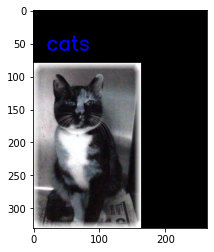

In [23]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
dict = {"[0]" : "cats",
        "[1]" : "dogs"}

def draw_test(name, pred, im):
    CatOrDog = dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, CatOrDog, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    plt.imshow(expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + str(path_class))
    file_path = path +"/" + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/gdrive/My Drive/new/test_set")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()